## Biological Research: Tier 3

In designing the spacecraft for an alien pilot, we would like to understand the biomechanics of the alien organism. This will let us set safe upper limits on acceleration, impulse from thrusters, and so on, to avoid injuring the pilot.

To study this without endangering a real alien, we will use a computer simulation called __finite element analysis__. This is a computational technique which works in a "divide and conquer" way. We would like to understand the physical equations which govern how a complicated object, like an alien's spine, behaves under various forces. However, these equations are hopelessly complicated, so we cannot solve them exactly. 

Instead, we will break up the complicated object into many small pieces, which are individually described by approximate equations that are much simpler to solve. After analyzing each of the small pieces in this "mesh," we will stitch together the results to get an approximate result for the entire system.

Let's see concretely how this works. Click inside the next cell and press Shift + Enter to run it.

In [14]:
import pycalculix as pyc
import matplotlib.pyplot as plt
import math

model_name = 'alien_barrel_roll'
model = pyc.FeaModel(model_name)
model.set_units('m')

Units have been set to m_N
For stress use Pa
For dist use m
For temp use K
For force use N
For time use s
For displ use m
For density use kg/(m^3)


An alien pilot may need to quickly spin within his vessel, for example to avoid collision with an undetected object like an asteroid. We would like to know how quickly, in RPM, our avoidance system can rotate without harming the pilot.

In the above cell, we have started a new project and set our units to SI (meters, etc.). In the next problem, we will approximate the body of our alien pilot with a few shapes.

Inserting line L17 into area A0 next to L13
 Inserting line into A0 outer lines
Arc inserted into area 0
Inserting line L18 into area A0 next to L12
 Inserting line into A0 outer lines
Arc inserted into area 0
Inserting line L19 into area A0 next to L0
 Inserting line into A0 outer lines
Arc inserted into area 0
Inserting line L20 into area A0 next to L11
 Inserting line into A0 outer lines
Arc inserted into area 0
Inserting line L21 into area A0 next to L1
 Inserting line into A0 outer lines
Arc inserted into area 0
Inserting line L22 into area A0 next to L10
 Inserting line into A0 outer lines
Arc inserted into area 0
Inserting line L23 into area A0 next to L2
 Inserting line into A0 outer lines
Arc inserted into area 0
Inserting line L24 into area A0 next to L9
 Inserting line into A0 outer lines
Arc inserted into area 0
File pilot_shape.png was saved.


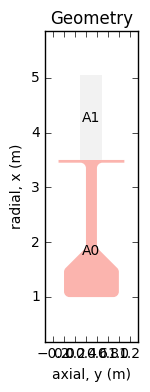

In [15]:
## Choose some numbers for the pilot's geometry.
rad_spine = 1
rad_hips = 3
shoulder_width = 1
shoulder_height = 0.5
shoulder_angle = 45
hip_width = 0.2
head_length = .5
head_th = 0.05
trunk_width = 0.4
trunk_height = 1
rad_head = 0.1

# Compute some other quantities.
shoulder_hip_delta = (shoulder_width - hip_width)/2
shoulder_hip_radians = math.tan(math.radians(shoulder_angle))*shoulder_hip_delta
trunk_height = rad_hips - head_th - shoulder_hip_radians - rad_spine
hip_trunk_delta = (hip_width + 2*head_length - trunk_width) / 2.0

# The hip bone's connected to the...
# :-P
head_loop = [[shoulder_height,0],[shoulder_hip_radians,shoulder_hip_delta],[trunk_height,0,],[0,-head_length],
             [head_th,0],[0,hip_trunk_delta],[0,trunk_width],[0,hip_trunk_delta],
             [-head_th,0],[0,-head_length],[-trunk_height,0],[-shoulder_hip_radians,shoulder_hip_delta],
             [-shoulder_height,0],[0,-shoulder_width]]
trunk_loop = [[trunk_height,0],[0,trunk_width],[-trunk_height,0],[0,-trunk_width]]

# Finally, build our pilot!
part = pyc.Part(model)
part.goto(rad_spine,0)
lines = []
for [drad, dax] in head_loop:
    [L, p1, p2] = part.draw_line_delta(drad, dax)
    lines.append(L)

mypt = lines[6].pt(0)
part.goto(mypt.x,mypt.y)
for [drad, dax] in trunk_loop:
    part.draw_line_delta(drad, dax)
    
fillet_list = [[13,0,rad_head],[12,13,rad_head],
               [0,1,rad_head],[11,12,rad_head],
               [1,2,rad_head],[10,11,rad_head],
               [2,3,rad_head],[9,10,rad_head]]
for [i1, i2, rad] in fillet_list:
    part.fillet_lines(lines[i1], lines[i2], rad)
    
# T
model.plot_geometry('pilot_shape', pnum=False, lnum=False)

Now we've built an approximate pilot shape, which looks like this:

![pilot](pilot_shape.png)

Eh, perhaps it's not the most realistic shape, but it will do just fine for our purposes.

Next we want to break down our shape into a __mesh__, spin it around really fast, and solve the equations which describe the distribution of stresses inside our pilot's body.

File: alien_barrel_roll.geo was written
C:\Users\cferko\Anaconda2\envs\py35\lib\site-packages\pycalculix\gmsh_win32\gmsh.exe alien_barrel_roll.geo -2 -o alien_barrel_roll.inp
File: alien_barrel_roll.inp was written
Meshing done!
File: alien_barrel_roll.msh was written
Re-indexing elements to min element number of: 1
Old min:5446  max:5821
New min:1  max:376
Elements: 376
Nodes: 1257
Done reading Calculix/Abaqus .inp file
File alien_barrel_roll_elem.png was saved.


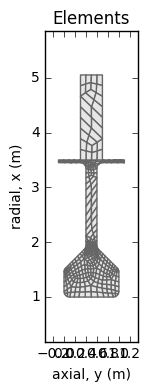

File alien_barrel_roll_constr.png was saved.


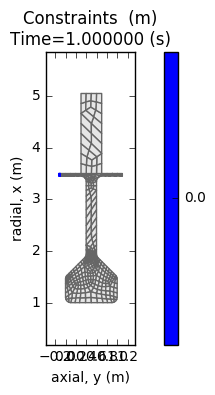

In [16]:
# Can our pilot handle 100 revolutions per minute?
model.set_rpm(100, part)

# This assumes that our pilot's left shoulder is strapped in.
model.set_constr('fix',part.left,'y')

# Use some measured numbers for the properties of alien bone
mat = pyc.Material('alien_bone')
mat.set_mech_props(8220, 208*10**9, 0.3)
model.set_matl(mat, part)

# Now create the mesh!
model.set_eshape('quad', 2)
model.set_etype('axisym', 'A0')
model.set_etype('plstress', 'A1', 0.1)
model.get_item('L15').set_ediv(8)
model.get_item('L6').set_ediv(8)
model.get_item('L2').set_ediv(24)
model.get_item('L10').set_ediv(24)
model.mesh(1.0, 'gmsh')

model.plot_elements(model_name+'_elem')
model.plot_constraints(model_name+'_constr')

Look at the two plots above -- the grid of tiny squares that was created over our pilot is the __mesh__ discussed above. Finally, we will solve the physical equations describing his rotation in each of these tiny elements, and combine the results.

Run the cell below to solve the problem and view the results!

INFO: 1257 nodes
INFO: 28 CPS8 elements
INFO: 28 total elements
INFO: 344 CAX8 elements
INFO: 372 total elements
INFO: 4 CAX6 elements
INFO: 376 total elements
File: alien_barrel_roll.inp was written
C:\Users\cferko\Anaconda2\envs\py35\lib\site-packages\pycalculix\calculix_win64\ccx.exe alien_barrel_roll
Solving done!
Reading results file: alien_barrel_roll.frd
Reading nodes
Reading displ storing: ux,uy,uz,utot
Reading stress storing: Sx,Sy,Sz,Sxy,Syz,Szx,Seqv,S1,S2,S3
Reading strain storing: ex,ey,ez,exy,eyz,ezx,eeqv,e1,e2,e3
Reading force storing: fx,fy,fz
The following times have been read:
[1.0]
Done reading file: alien_barrel_roll.frd
Results file time set to: 1.000000
The following times have been read:
[1.0]
Results from file: alien_barrel_roll.dat have been read.
File alien_barrel_roll_Sx.png was saved.


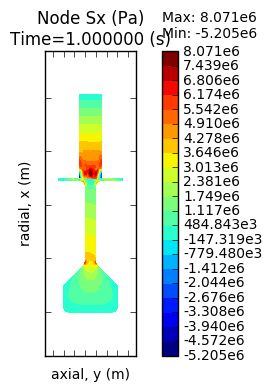

File alien_barrel_roll_Sy.png was saved.


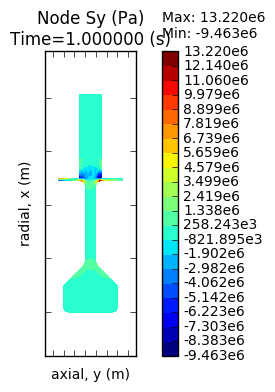

File alien_barrel_roll_Sz.png was saved.


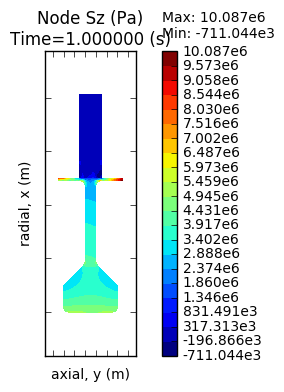

File alien_barrel_roll_S1.png was saved.


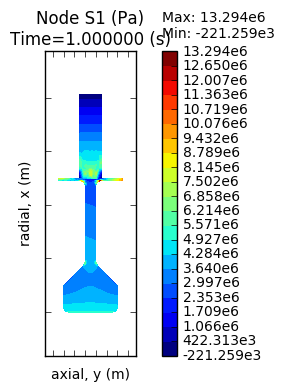

File alien_barrel_roll_S2.png was saved.


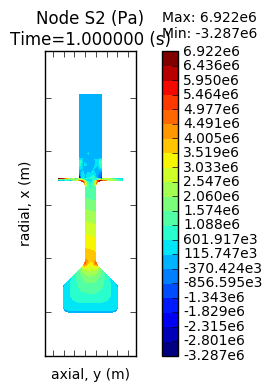

File alien_barrel_roll_S3.png was saved.


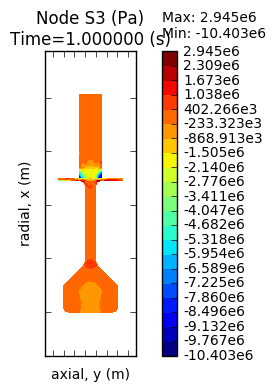

File alien_barrel_roll_Seqv.png was saved.


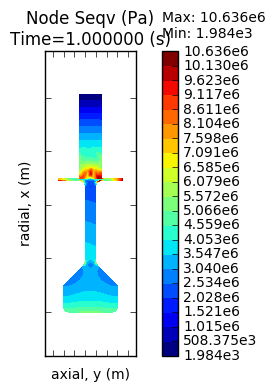

File alien_barrel_roll_ux.png was saved.


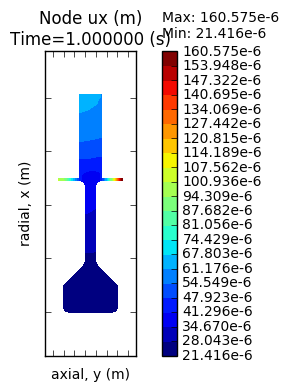

File alien_barrel_roll_uy.png was saved.


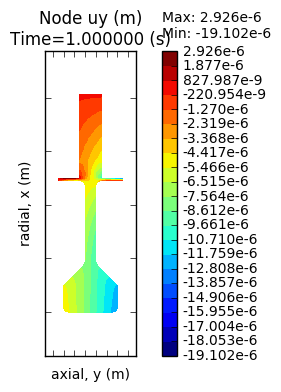

File alien_barrel_roll_uz.png was saved.


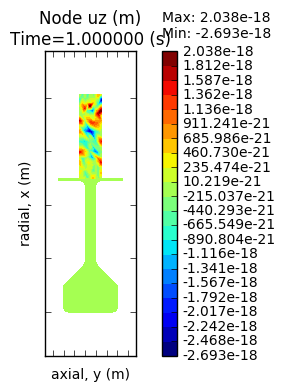

File alien_barrel_roll_utot.png was saved.


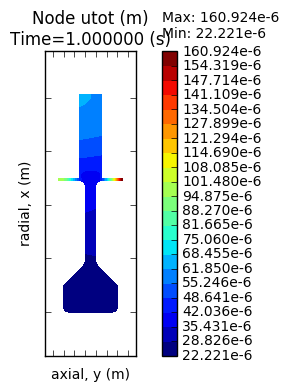

In [17]:
# Let's solve this thing!
prob = pyc.Problem(model, 'struct')
prob.solve()

# Now, look at the results.
disp = True
g = 0.0 
fields = 'Sx,Sy,Sz,S1,S2,S3,Seqv,ux,uy,uz,utot'
fields = fields.split(',')
for field in fields:
    fname = model_name+'_'+field
    prob.rfile.nplot(field, fname, display=disp, gmult=g)

The $S$ variables plotted along the pilot's bodies above are __stresses__, which measures the internal forces of one part of the pilot's body pushing on another. Stress has units of force per area, like pressure.

__Your job.__Human bone breaks under a stress of around $16,000$ Pa. Assuming that the alien physiology is not much more sturdy than our own, would you advise the engineer designing our "evasive maneuver" system to allow barrel rolls with speeds of 100 rpm?